# Demo: Synthetic CCC with Tangram2-evalkit, Tangram2-mapping and Tangram2-CCC

In this short tutorial we:

1. Start from a real mouse cortex scRNA-seq dataset (`squidpy.datasets.sc_mouse_cortex`).
2. Use **Tangram2-evalkit** (`cellmix`) to create a **synthetic Visium-like spatial dataset**
   where we *inject a known cell–cell interaction*:
   - a sender cell type expressing a "signal" gene,
   - a receiver cell type whose "effect" genes change when near senders.
3. Use **Tangram2-mapping** (via `evalkit.met`) to map scRNA-seq cells to spatial spots.
4. Run **Tangram2-CCC** (`TangramCCC`) on the mapped data to infer interaction coefficients.
5. Compare the inferred interaction scores to the *ground-truth effect genes* and compute AUROC.

<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com) and Alma Andersson (andera29@gene.com)<br>
<b>Date</b> : 12/07/2025

## Imports and basic setup

In [1]:
import tangram2 as tg2
import anndata as ad
import numpy as np
import scanpy as sc
import squidpy as sq

from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit nicer
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (5, 4)

/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is

## 1. Load scRNA-seq data and choose sender / receiver types

We use the mouse cortex dataset from Squidpy, and treat `cell_subclass` as our cell-type label.
For simplicity, we just pick the **two most abundant subclasses**:

* one as **receiver** (index 0)  
* one as **sender** (index 1)

In [2]:
adata = sq.datasets.sc_mouse_cortex()
label_col = "cell_subclass"

# show counts per subclass
adata.obs[label_col].value_counts().head()

# choose receiver and sender from the two most frequent subclasses
receiver_name, signaler_name = adata.obs[label_col].value_counts().index[0:2]
print("Receiver subclass:", receiver_name)
print("Sender   subclass:", signaler_name)


Receiver subclass: L5 IT
Sender   subclass: Vip


## 2. Simple scRNA-seq preprocessing helper

In the original synthetic evaluation notebook there was a `pp_adata` helper.
Here we define a small version that:
* normalizes total counts  
* log-transforms  
* selects highly variable genes (HVGs)

In [3]:
def pp_adata(adata_sc: ad.AnnData, n_top_genes: int = 2000) -> ad.AnnData:
    """Basic preprocessing: library-size normalize, log1p, mark HVGs."""
    adata_sc = adata_sc.copy()
    sc.pp.normalize_total(adata_sc, target_sum=1e4)
    sc.pp.log1p(adata_sc)
    sc.pp.highly_variable_genes(
        adata_sc, n_top_genes=n_top_genes, subset=False
    )
    return adata_sc

## 3. One end-to-end synthetic run (Tangram2-evalkit → mapping → CCC)

We wrap the whole pipeline (data generation + mapping + CCC + scoring)
into a single function `run_one_simulation` to keep the main notebook clean.

**Synthetic parameters (you can tweak these):**

* `effect_direction` – `"up"` (receiver effect genes up-regulated near senders, the direction can also be set as 'down' or 'both')  
* `effect_scaling` – how strong the effect is  
* `effect_base` – baseline quantile of effect gene expression in non-interacting cells  
* `n_spots` – number of spatial spots  
* `n_effect_genes` – how many downstream effect genes we inject



In [4]:
def run_one_simulation(
    adata_seed: ad.AnnData,
    label_col: str,
    receiver_name: str,
    signaler_name: str,
    effect_direction: str = "up",
    effect_scaling: float = 3.0,
    effect_base: float = 0.95,
    n_spots: int = 250,
    n_effect_genes: int = 25,
    seed: int = 0,
):
    """
    One synthetic CCC experiment:

      1) generate synthetic spatial + scRNA with Tangram2-evalkit cellmix
      2) map cells with Tangram2-mapping (via evalkit.met)
      3) infer interactions with Tangram2-CCC
      4) return:
           - synthetic ad_sp, ad_sc
           - beta_df: interaction coefficients for all receiver/sender/gene combinations
           - params: the synthetic settings used

    NOTE: This function does *not* perform any evaluation (no AUROC).
          Evaluation is done later using 'beta_df' and 'ad_sc'.
    """
    np.random.seed(seed)

    # --- 3.1 Generate synthetic data with cellmix ---------------------------
    ad_sp, ad_sc = tg2.evalkit.datagen.cellmix.cellmix.cellmix(
        adata_seed.copy(),
        n_spots=n_spots,
        n_cells_per_spot=10,
        n_types_per_spot=5,
        label_col=label_col,
        signaler_names=signaler_name,
        receiver_names=receiver_name,
        n_interactions=1,
        effect_size=n_effect_genes,
        effect_direction=effect_direction,
        signal_effect_base=effect_base,
        signal_effect_scaling=effect_scaling,
        p_inter=0.8,
        p_signal_spots=0.9,
    )

    # --- 3.2 Preprocess synthetic scRNA-seq and get HVGs -------------------
    ad_sc = pp_adata(ad_sc)
    hvg_genes = ad_sc.var_names[ad_sc.var.highly_variable.values].tolist()

    # --- 3.3 Prepare evalkit "input_dict" for Tangram2-mapping ------------
    input_dict = tg2.evalkit.met.utils.adatas_to_input(
        {"from": ad_sc.copy(), "to": ad_sp.copy()},
        categorical_labels={"from": [label_col]},  # include subclass in design matrix
    )

    # Standard Tangram2 preprocessing (normalization, gene filtering, etc.)
    tg2.evalkit.met.pp.StandardTangram2.run(input_dict)

    # --- 3.4 Run Tangram2-mapping -----------------------------------------
    map_res = tg2.evalkit.met.map_methods.Tangram2Map.run(
        input_dict,
        num_epochs=1000,
        genes=hvg_genes,
    )

    # Update input_dict with mapping result (so CCC sees the mapping)
    input_dict.update(map_res)

    # --- 3.5 Run Tangram2-CCC on mapped data ------------------------------
    inter_res = tg2.ccc.TangramCCC.run(
        input_dict,
        n_epochs=1000,
        seed=seed,
        verbose=False,
    )

    # --- 3.6 Extract interaction coefficients only -------------------------
    # inter_res["beta"] is a (receiver_type x sender_type x gene) tensor-like object
    beta_df = inter_res["beta"].to_dataframe()["beta"]
    # beta_df is a pandas Series with a MultiIndex (receiver, sender, gene)

    return {
        "ad_sp": ad_sp,
        "ad_sc": ad_sc,
        "beta_df": beta_df,
        "params": dict(
            effect_direction=effect_direction,
            effect_scaling=effect_scaling,
            effect_base=effect_base,
            n_spots=n_spots,
            n_effect_genes=n_effect_genes,
        ),
    }

## 4. Run a single synthetic experiment (up-regulated effect)

Let’s run **one** reasonably strong interaction:

* `effect_direction = "up"`  
* `effect_scaling = 3.0`  
* `effect_base = 0.95`  
* `n_spots = 250`  
* `n_effect_genes = 25`  

At this stage we only care about **getting `beta_df`** and the synthetic data;
we will evaluate in the next section.

In [5]:
demo_up = run_one_simulation(
    adata_seed=adata,
    label_col=label_col,
    receiver_name=receiver_name,
    signaler_name=signaler_name,
    effect_direction="up",
    effect_scaling=3.0,
    effect_base=0.99,
    n_spots=250,
    n_effect_genes=25,
    seed=0,
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 2000 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.860, KL reg: 3.233, Entropy reg: -8.158
Score: 0.972, KL reg: 3.136, Entropy reg: -7.007
Score: 0.974, KL reg: 3.135, Entropy reg: -6.696
Score: 0.974, KL reg: 3.135, Entropy reg: -6.613
Score: 0.974, KL reg: 3.135, Entropy reg: -6.571
Score: 0.974, KL reg: 3.135, Entropy reg: -6.546
Score: 0.974, KL reg: 3.135, Entropy reg: -6.530
Score: 0.974, KL reg: 3.135, Entropy reg: -6.520
Score: 0.974, KL reg: 3.136, Entropy reg: -6.513


INFO:root:Renormalizing Single cell data


Score: 0.974, KL reg: 3.135, Entropy reg: -6.507


INFO:root:Begin training with 2000 genes and rna_count_based density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.932, KL reg: 0.060, Entropy reg: -12563.852
Score: 0.996, KL reg: 0.000, Entropy reg: -1893.628
Score: 0.997, KL reg: 0.000, Entropy reg: -740.871
Score: 0.997, KL reg: 0.000, Entropy reg: -616.184
Score: 0.997, KL reg: 0.000, Entropy reg: -564.874
Score: 0.997, KL reg: 0.000, Entropy reg: -543.674
Score: 0.997, KL reg: 0.000, Entropy reg: -530.444
Score: 0.997, KL reg: 0.000, Entropy reg: -521.735
Score: 0.997, KL reg: 0.000, Entropy reg: -515.437
Score: 0.997, KL reg: 0.000, Entropy reg: -511.039


INFO:root:Saving results..
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK

In [6]:
demo_up['params']

{'effect_direction': 'up',
 'effect_scaling': 3.0,
 'effect_base': 0.99,
 'n_spots': 250,
 'n_effect_genes': 25}

For the demo_up["beta_df"], 'labels' is the receiver cell type, 'labels_' is the sender cell type, For convenience, we create a single string key 'inter' that encodes the receiver–sender pair as "receiver_vs_sender".
Drop 'labels' and 'labels_' so the main columns are:
  - 'feature' : gene
  - 'beta'    : interaction coefficient
  - 'inter'   : receiver_vs_sender interaction label

In [7]:
beta_up = demo_up['beta_df'].reset_index()
beta_up['inter'] = beta_up['labels'].astype(str) + '_vs_' + beta_up['labels_'].astype(str)
beta_up.drop(labels=['labels', 'labels_'], inplace=True, axis=1)

In [8]:
beta_up

,features,beta,inter
0,0610005c13rik,-0.014723,Astro_vs_Astro
1,0610006l08rik,-0.000190,Astro_vs_Astro
2,0610007p14rik,0.202770,Astro_vs_Astro
3,0610009b22rik,0.030268,Astro_vs_Astro
4,0610009e02rik,-0.033288,Astro_vs_Astro
...,...,...,...
19173600,effect_0_20,0.109283,Vip_vs_Vip
19173601,effect_0_21,0.028939,Vip_vs_Vip
19173602,effect_0_22,0.041691,Vip_vs_Vip
19173603,effect_0_23,-0.055167,Vip_vs_Vip


## 5. Evaluation based on ground truth
In a typical Tangram2-CCC analysis, 'beta' is the main output used for
downstream biology: for each (receiver, sender, gene) triplet, the beta
coefficient tells us how much the interaction between the two cell types
modulates that gene in the receiver.

In this demo we are using a simulated dataset with known "effect" genes,
so we can go one step further and *validate* the model by checking how well
the inferred beta values recover these ground-truth effect genes (e.g. via AUROC).

Now that we have:

* `demo_up["beta_df"]` – interaction coefficients for all (receiver, sender, gene), and  
* `demo_up["ad_sc"]` – the synthetic scRNA-seq with ground-truth interaction labels,

we can:

1. Extract the coefficients for our specific **receiver–sender pair**.  
2. Build a score table for genes.  
3. Identify the **ground-truth effect genes** (named `effect_*` by evalkit).  
4. Compute an **AUROC** using `tg2.evalkit.dig.dea.compute_dea_score`.  
5. Visualize effect vs non-effect genes.

In [9]:
# 5.1 Extract beta for the chosen receiver–sender pair
beta_df = demo_up["beta_df"]
ad_sc_up = demo_up["ad_sc"]

# scores for this specific receiver–sender pair
scores_up = beta_df.loc[receiver_name, signaler_name].sort_values(ascending=False)
scores_up = pd.DataFrame(scores_up, columns=["beta"])
scores_up["names"] = scores_up.index

In [10]:
# 5.2 Ground-truth effect genes are named "effect_*" in the synthetic scRNA
effect_genes_up = [g for g in ad_sc_up.var.index if g.startswith("effect_")]

# add a column flagging ground-truth effect genes
scores_up["is_effect"] = scores_up["names"].isin(effect_genes_up)

In [11]:
# 5.3 Compute AUROC of beta vs. GT effect gene set
dea_score_up = tg2.evalkit.dig.dea.compute_dea_score(
    scores_up,
    effect=effect_genes_up,
    score_by="beta",
    method="auroc",
    reverse=False,  # effect_direction == "up"
)

print("AUROC (up-regulated effects):", dea_score_up["score"])

AUROC (up-regulated effects): 0.9774500276090559


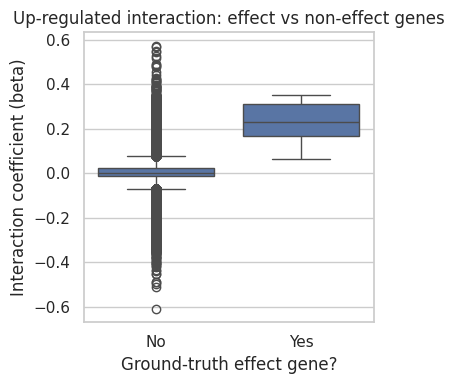

In [13]:
# ### 5.2 Simple visualization: beta for effect vs. non-effect genes

# %%
plt.figure(figsize=(4, 4))
sns.boxplot(
    data=scores_up,
    x="is_effect",
    y="beta",
)
plt.xlabel("Ground-truth effect gene?")
plt.ylabel("Interaction coefficient (beta)")
plt.xticks([0, 1], ["No", "Yes"])
plt.title("Up-regulated interaction: effect vs non-effect genes")
plt.tight_layout()
plt.show()